In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt


from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

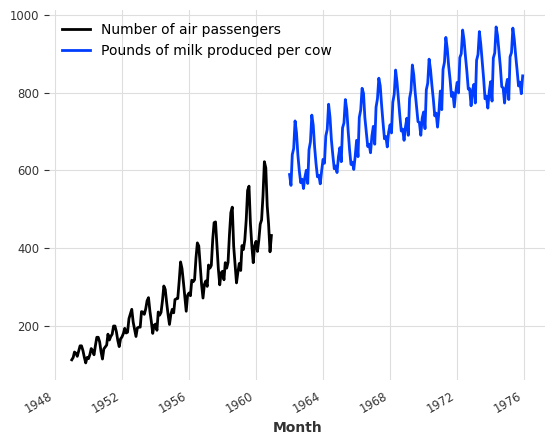

In [4]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();



In [59]:
import torch
import glob
import geopandas as gpd
import xarray as xr

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [14]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')


meteo_input = ['prcp_e5l',  't_max_e5l', 't_min_e5l']
# q_mm_day or lvl_sm
hydro_target = 'lvl_sm'


Using device: cuda

NVIDIA GeForce RTX 3080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [16]:
if (hydro_target == 'lvl_mbs') | (hydro_target == 'lvl_sm'):
    static_parameters = ['for_pc_sse', 'crp_pc_sse',
                         'inu_pc_ult', 'ire_pc_sse',
                         'lka_pc_use', 'prm_pc_sse',
                         'pst_pc_sse', 'cly_pc_sav',
                         'slt_pc_sav', 'snd_pc_sav',
                         'kar_pc_sse', 'urb_pc_sse',
                         'gwt_cm_sav', 'lkv_mc_usu',
                         'rev_mc_usu', 'sgr_dk_sav',
                         'slp_dg_sav', 'ws_area',
                         'ele_mt_sav', 'height_bs']
    nc_variable = 'nc_all_h'
else:
    static_parameters = ['for_pc_sse', 'crp_pc_sse',
                         'inu_pc_ult', 'ire_pc_sse',
                         'lka_pc_use', 'prm_pc_sse',
                         'pst_pc_sse', 'cly_pc_sav',
                         'slt_pc_sav', 'snd_pc_sav',
                         'kar_pc_sse', 'urb_pc_sse',
                         'gwt_cm_sav', 'lkv_mc_usu',
                         'rev_mc_usu', 'sgr_dk_sav',
                         'slp_dg_sav', 'ws_area',
                         'ele_mt_sav']
    nc_variable = 'nc_all_q'

ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')

In [28]:
with_static = True
index_col = 'gauge_id'
static_path = '../geo_data/attributes/static_with_height.csv'
nc_files = glob.glob(f'../geo_data/great_db/{nc_variable}/*.nc')
area_index = ws_file.index

In [24]:
def file_checker(file_path: str,
                 meteo_predictors: list,
                 hydro_target: str):
    nan_vals = xr.open_dataset(
        file_path).to_dataframe()[
            [hydro_target,
             *meteo_predictors]].isna().sum().sum()

    condition = nan_vals != 0

    return condition

In [35]:
if with_static:
    static_attributes = pd.read_csv(static_path,
                                    index_col=index_col)
    static_attributes.index = static_attributes.index.astype(str)
    static_attributes = static_attributes.replace(np.NaN, 0.)
else:
    static_attributes = None

res_file = list()

for file_path in nc_files[:10]:
    gauge_id = file_path.split('/')[-1][:-3]
    try:
        if isinstance(static_attributes, pd.DataFrame):
            static_attributes = static_attributes[[*static_parameters]]
            gauge_static = static_attributes.loc[[gauge_id], :]
        else:
            gauge_static = None
    except KeyError:
        print(f'No data for {gauge_id} !')
        continue
    cond = file_checker(file_path=file_path,
                        meteo_predictors=meteo_input,
                        hydro_target=hydro_target)
    if cond:
        continue
    if gauge_id not in area_index:
        continue
    file = xr.open_dataset(file_path).to_dataframe()
    file = file.reset_index()
    if isinstance(gauge_static, pd.DataFrame):
            for col in gauge_static.columns:
                file[col] = gauge_static.loc[gauge_id, col]

    res_file.append(file)

file = pd.concat(res_file, axis=0)
file = file.reset_index(drop=True)

In [67]:
scaler = StandardScaler()
file[[hydro_target, *meteo_input, *static_parameters]] = scaler.fit_transform(
    file[[hydro_target, *meteo_input, *static_parameters]])

gauge_time_series = TimeSeries.from_group_dataframe(
    df=file,
    time_col='date',
    group_cols='gauge_id',
    static_cols=static_parameters,
    value_cols=meteo_input)

In [87]:
train_val_dict = dict()

train_start = '2008-01-01'
train_end = '2016-12-31'

val_start = '2017-01-01'
val_end = '2018-12-31'

pred_start = '2018-01-01'
pred_end = '2020-12-31'

# train period
train_val_dict['train'] = list()
for g in gauge_time_series:
    train_val_dict['train'].append(g.split_after(
        pd.Timestamp(train_end))[0])
# val period
train_val_dict['val'] = list()
for g in gauge_time_series:
    train_val_dict['val'].append(g.split_before(
        pd.Timestamp(val_start))[1].split_after(
            pd.Timestamp(val_end))[0])
# test period
train_val_dict['test'] = list()
for g in gauge_time_series:
    train_val_dict['test'].append(g.split_before(
        pd.Timestamp(pred_start))[1].split_after(
            pd.Timestamp(pred_end))[0])

In [97]:
train_val_dict['train'][0]

<TimeSeries (DataArray) (date: 3288, component: 3, sample: 1)>
array([[[-0.50039429],
        [-2.57376168],
        [-2.36220925]],

       [[-0.46228448],
        [-2.46868376],
        [-2.22436993]],

       [[-0.22276252],
        [-2.42949721],
        [-2.16197277]],

       ...,

       [[-0.43740687],
        [-2.4858389 ],
        [-2.36568418]],

       [[-0.37933934],
        [-2.36704038],
        [-2.17969584]],

       [[-0.50057946],
        [-2.53258578],
        [-2.47820428]]])
Coordinates:
  * date       (date) datetime64[ns] 2008-01-01 2008-01-02 ... 2016-12-31
  * component  (component) object 'prcp_e5l' 't_max_e5l' 't_min_e5l'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates gauge_id  for_pc_sse  crp_pc_sse  i...
    hierarchy:          None

In [ ]:


# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)



In [98]:
covariates_transformed

<TimeSeries (DataArray) (Month: 144, component: 3, sample: 1)>
array([[[0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.09090909],
        [0.00934579]],

       [[0.        ],
        [0.18181819],
        [0.01869159]],

       [[0.        ],
        [0.27272728],
        [0.02803738]],

       [[0.        ],
        [0.36363637],
        [0.03738318]],

...

       [[1.375     ],
        [0.6363636 ],
        [1.2990654 ]],

       [[1.375     ],
        [0.72727275],
        [1.3084111 ]],

       [[1.375     ],
        [0.8181819 ],
        [1.317757  ]],

       [[1.375     ],
        [0.9090909 ],
        [1.3271028 ]],

       [[1.375     ],
        [1.        ],
        [1.3364486 ]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 'year' 'month' 'linear_increase'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [7]:
# generate an DataFrame example
df = pd.DataFrame(
    data={
        "dates": [
            "2020-01-01",
            "2020-01-02",
            "2020-01-03",
            "2020-01-01",
            "2020-01-02",
            "2020-01-03",
        ],
        "comp1": np.random.random((6,)),
        "comp2": np.random.random((6,)),
        "comp3": np.random.random((6,)),
        "ID": ["SERIES1", "SERIES1", "SERIES1", "SERIES2", "SERIES2", "SERIES2"],
        "var1": [0.5, 0.5, 0.5, 0.75, 0.75, 0.75],
    }
)

In [12]:
df

,dates,comp1,comp2,comp3,ID,var1
0,2020-01-01,0.455566,0.274513,0.930958,SERIES1,0.50
1,2020-01-02,0.879770,0.738258,0.245704,SERIES1,0.50
2,2020-01-03,0.730323,0.417726,0.210264,SERIES1,0.50
3,2020-01-01,0.478339,0.755322,0.282830,SERIES2,0.75
4,2020-01-02,0.210218,0.297144,0.333329,SERIES2,0.75
5,2020-01-03,0.310734,0.711747,0.030325,SERIES2,0.75


In [9]:
series_multi = TimeSeries.from_group_dataframe(
    df,
    time_col="dates",
    group_cols="ID",  # individual time series are extracted by grouping `df` by `group_cols`
    static_cols=[
        "var1"
    ],  # also extract these additional columns as static covariates (without grouping)
    value_cols=[
        "comp1",
        "comp2",
        "comp3",
    ],  # optionally, specify the time varying columns
)

In [11]:
series_multi[0]

<TimeSeries (DataArray) (dates: 3, component: 3, sample: 1)>
array([[[0.45556644],
        [0.27451346],
        [0.93095825]],

       [[0.87976954],
        [0.73825818],
        [0.24570359]],

       [[0.7303229 ],
        [0.41772568],
        [0.21026374]]])
Coordinates:
  * dates      (dates) datetime64[ns] 2020-01-01 2020-01-02 2020-01-03
  * component  (component) object 'comp1' 'comp2' 'comp3'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates       ID  var1\nglobal_components  ...
    hierarchy:          None

In [ ]:
a

In [90]:
# Read data
series = AirPassengersDataset().load()

# we convert monthly number of passengers to average daily number of passengers per month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Create training and validation sets:
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(
    series, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [20]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
)

In [21]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

A Jupyter Widget

TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders=None, random_state=42)

A Jupyter Widget

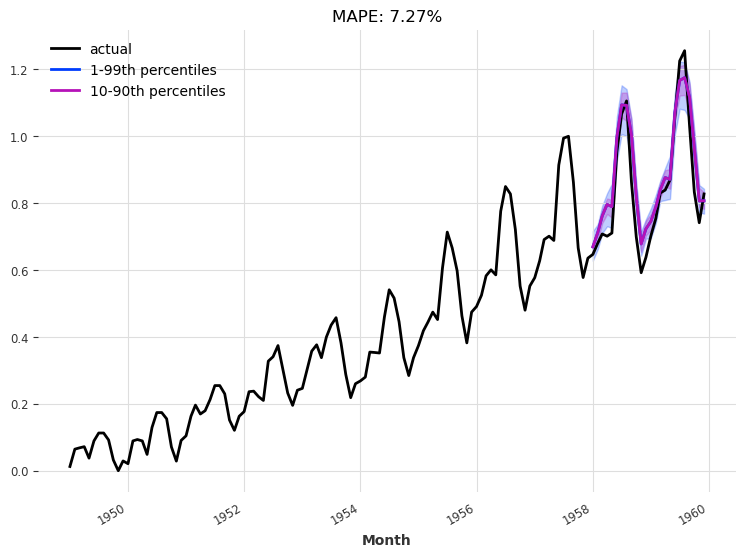

In [22]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


eval_model(my_model, 24, series_transformed, val_transformed)

